# Test Tensorflow / Keras Models
This notebook tests some machine learning on fitted TES data using Keras and Tensorflow

In [82]:
import numpy as np
import glob
import os
import itertools
import matplotlib.pyplot as plt
import time
import copy
from fastespy.readpydata import convert_data_to_ML_format
from fastespy.plotting import plot_2d_hist, plot_scatter_w_hist
from fastespy.ml import MLHyperParTuning, significance
from fastespy.analysis import init_logging
from pathlib import PosixPath
import logging
from sklearn.decomposition import PCA

import sys
sys.path.append("/Users/manuelmeyer/Python/fastespy/fastespy/scripts/")
from ml_intrinsic_bkg import load_data

In [83]:
%matplotlib inline

## Read data 

In [84]:
path = "/Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/"
in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
#files

8


In [85]:
init_logging("INFO", color=True)

In [86]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

remove.append('constant')  # this seems to help

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

# convert data to ML format
X, y = convert_data_to_ML_format(result,
                                 feature_names,
                                 bkg_type=0,
                                 signal_type=1)

3247362142.py:   3 --- INFO: Using files:
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-1-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-4-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-2-triggertimefixed.pickle.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-36hrs-1-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/newsettings-0.3RN-1.5GHzGBWP-50MHz-20mV-light-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Downloads/IntrinsicsData_NewSetup/intrinsics-0.3RN-1.5GHzGBWP-50MHz-20mV-5day-5-triggertimefixed.npy
3247362142.py:   5 --- INFO: /Users/manuelmeyer/Download

In [87]:
X_log, y_log = MLHyperParTuning.transform_data_log(X.copy(), y.copy(), feature_names)

Discarded 89 triggers in log transform


/Users/manuelmeyer/Python/fastespy/fastespy/ml.py:319: RuntimeWarning: divide by zero encountered in log10
  X[:, j] = np.log10(-X[:, j])


In [88]:
k_folds = 5
ml = MLHyperParTuning(X_log, y_log,
                      valid_fraction=1. / k_folds,
                      stratify=True,
                      random_state=42,
                      n_splits=k_folds)

# now test and train data are contained 
# in ml.X_test, ml.X_train, ml.y_test, and ml.y_train

To Do:
- compare with sklearn results
- compare with previous data set
- more things to test: weighting -> does not work on new mac, data augmentation, regularization with dropout?
- hyper parameter tuning
- learning curve: you need to write this yourself, see, e.g., https://keras.io/examples/keras_recipes/sample_size_estimate/ 
- Start with CNNs: https://keras.io/examples/timeseries/timeseries_classification_from_scratch/ and https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline
- check out unsupervised learning and other examples here: https://keras.io/examples/timeseries/ 
- understand and implement resnet layers

In [89]:
x = ml.kf.split(ml.X_train, ml.y_train)

In [90]:
# generate train and validation set from stratified K fold

for train_index, val_index in ml._kf.split(ml.X_train, ml.y_train):
    
    # training data set
    X_train, y_train = ml.X_train[train_index], ml.y_train[train_index]
    
    # validation data set
    X_val, y_val = ml.X_train[val_index], ml.y_train[val_index]
    
# check class proportion
print(y_train.sum() / y_train.size)
print(y_val.sum() / y_val.size)
print(y_train.size)
print(y_val.size)
print(ml.y_test.size)

0.23717571333254836
0.23724289527398335
25479
6369
7963


## Start with Keras and tensorflow

In [91]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [92]:
use_pca = False # I haven't seen any gains with this

In [93]:
# normalize the input data
normalizer = Normalization(axis=-1)

# transfrom data with PCA
if use_pca:
    pca = PCA(n_components=None)  # None: all components
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(ml.X_test)
else:
    X_test = ml.X_test

# adapt to training data
normalizer.adapt(X_train)

# normalize training data
X_train = normalizer(X_train)
X_val = normalizer(X_val)
X_test = normalizer(X_test)

In [94]:
print(np.var(X_train, axis=0))
print(np.var(X_val, axis=0))
print(np.var(X_test, axis=0))

[0.9999836  0.99999964 1.0000027  0.99999785 0.9999997  0.9999974 ]
[1.003187  1.0076953 0.989486  0.9892453 0.9987803 1.0009006]
[1.0304174  1.0032228  0.9808954  0.974932   0.95843047 0.98772496]


### Building a first simple DNN

In [95]:
# define different metrics
# see also https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

adam = keras.optimizers.Adam(learning_rate=3e-4)


In [96]:
# initializing the sequential model
def make_model(metrics=metrics,
               output_bias=None,
               n_layers=3,
               n_nodes=100,
               dropout=0., 
               l2_regularizer=None):
    
    model = keras.Sequential(name="dnn_test")
    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    if l2_regularizer is not None:
        l2_regularizer = keras.regularizers.l2(l2_regularizer)
    
    # adding the input layer
    model.add(keras.layers.Input(shape=(X_train.shape[1])))
    
    # hidden layers
    for i in range(n_layers):
        model.add(keras.layers.Dense(n_nodes,
                                     activation='relu',
                                     name='dense{0:n}'.format(i + 1),
                                     kernel_regularizer=l2_regularizer,
                                     bias_regularizer=l2_regularizer
                                    )
                 )
        if dropout > 0.:
            model.add(keras.layers.Dropout(dropout))
    
    # output
    model.add(keras.layers.Dense(1, activation='sigmoid', name='output',
                                 bias_initializer=output_bias)) # output layer for binary classification
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=adam,
        metrics=metrics
    )
    
    return model

In [97]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

In [98]:
# compute initial bias
# makes sense for imbalanced data, see the imbalanced data tutorial

initial_bias = np.array([np.log(y_train.sum() / np.invert(y_train.astype(bool)).astype(int).sum())])

print(initial_bias)
print(y_train.sum() / np.invert(y_train.astype(bool)).astype(int).sum())

[-1.16822644]
0.3109178843383412


In [99]:
model = make_model(n_nodes=n_nodes,
                   n_layers=n_layers,
                   l2_regularizer=l2_regularizer,
                   output_bias=np.array([initial_bias]),
                   dropout=dropout
                  )

In [100]:
model.output_shape

(None, 1)

In [101]:
model.summary()

Model: "dnn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               700       
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense4 (Dense)               (None, 100)               101

In [102]:
EPOCHS = 100
BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch

# early stopping if loss of validation set does not improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


In [103]:
# test the model
# with output bias, it should be roughly the class imbalance
print(y_train.sum()/ y_train.size)
model.predict(X_train[:10])

0.23717571333254836


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x150639ee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


array([[0.23157182],
       [0.2332849 ],
       [0.2327527 ],
       [0.22569555],
       [0.2304453 ],
       [0.22244921],
       [0.22634685],
       [0.22572385],
       [0.2217248 ],
       [0.22920318]], dtype=float32)

In [104]:
results = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1782ce3a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [105]:
# check the loss. if initial bias is correct, you should get something of the order of
# -ln(1 / n_classes) = ln(2)
print(np.log(2.), results['loss'])

0.6931471805599453 0.5515455007553101


In [106]:
p0 = 1. / (1. + np.exp(-initial_bias))
print (-p0 * np.log(p0) - (1. - p0) * np.log(1. - p0))

[0.54780251]


In [107]:
# how to check bias value
model.layers[-1].bias.value()

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.1682265], dtype=float32)>

In [108]:
import tempfile
import os

Save the initial weights

In [109]:
initial_weights = os.path.join(tempfile.mkdtemp(), f'initial_weights_{n_layers}_{n_nodes}')
model.save_weights(initial_weights)

In [110]:
# check if new bias helps
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer, dropout=dropout)
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0
)

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x1533b2040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x152633280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [111]:
# now with bias
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer, dropout=dropout)
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_val, y_val), 
    verbose=0
)


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x151b813a0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x152e67d30> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [112]:
# plot the results 
def plot_metric(history, metric="loss", **kwargs):
    label = kwargs.pop('label', '')
    plt.semilogy(history.epoch, history.history[metric], label='Train ' + label, **kwargs)
    
    kwargs.pop('ls', None)
    plt.semilogy(history.epoch, history.history[f'val_{metric}'], label='Val ' + label, ls='--', **kwargs)
    plt.xlabel('Epoch')
    plt.ylabel(metric)


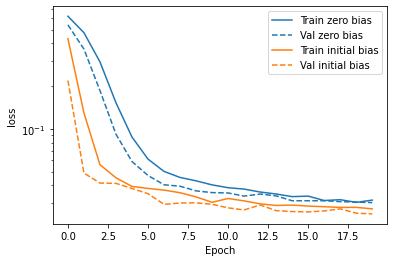

In [113]:
plot_metric(zero_bias_history, metric='loss', label='zero bias', color='C0')
plot_metric(careful_bias_history, metric='loss' , label='initial bias', color='C1')
plt.legend()

The initial bias seems to help slightly.

### Train the full model

In [114]:
use_weights = False # setting to true will let notebook crash on my new mac....

# weighting following
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = 1 / (y.size - y.sum()) * (y.size / 2.0)
weight_for_1 = 1 / y.sum() * (y.size / 2.0)

if use_weights:
    class_weight = {0: weight_for_0, 1: weight_for_1}
else:
    class_weight = None
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))



Weight for class 0: 0.66
Weight for class 1: 2.11


In [115]:
# now with bias
model = make_model(n_nodes=n_nodes, n_layers=n_layers, l2_regularizer=l2_regularizer, dropout=dropout)
print(model.layers[-1].bias.value())
model.summary()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val), 
    verbose=0,
    class_weight=class_weight
)


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2924b4940> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


tf.Tensor([1.2918187], shape=(1,), dtype=float32)
Model: "dnn_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 100)               700       
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense2 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_16 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense3 (Dense)               (None, 100)               10100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense4 (

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2976a81f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-08-23 14:58:25.629938: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-23 14:58:25.630336: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-23 14:58:25.630711: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-08-23 14:58

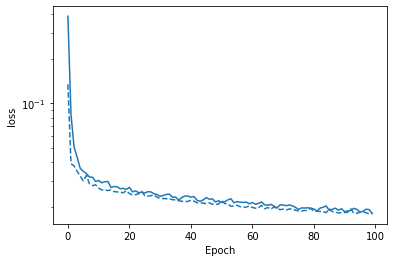

In [116]:
plot_metric(baseline_history, color="C0")

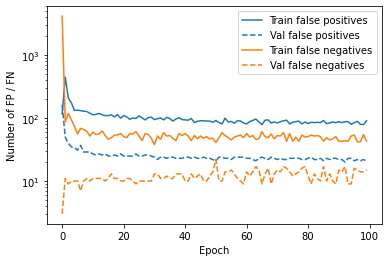

In [117]:
plot_metric(baseline_history, metric="fp", color="C0", label="false positives")
plot_metric(baseline_history, metric="fn", color="C1", label="false negatives")
plt.ylabel("Number of FP / FN")
plt.legend()

In [118]:
# evaluate model on test set
test_scores = model.evaluate(X_test, ml.y_test, verbose=2, return_dict=True)
print("Test loss:", test_scores["loss"])
print("Test accuracy:", test_scores["accuracy"])
print(test_scores)

249/249 - 0s - loss: 0.0215 - tp: 1865.0000 - fp: 30.0000 - tn: 6044.0000 - fn: 24.0000 - accuracy: 0.9932 - precision: 0.9842 - recall: 0.9873 - auc: 0.9991 - prc: 0.9953
Test loss: 0.021490996703505516
Test accuracy: 0.9932186603546143
{'loss': 0.021490996703505516, 'tp': 1865.0, 'fp': 30.0, 'tn': 6044.0, 'fn': 24.0, 'accuracy': 0.9932186603546143, 'precision': 0.9841688871383667, 'recall': 0.9872948527336121, 'auc': 0.999110996723175, 'prc': 0.9953464865684509}


In [119]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x291dcf4c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [120]:
threshold = 0.5 # threshold to classify event as "signal"
class_pred_test = (y_pred_test > threshold).flatten().astype(int)
class_pred_val = (y_pred_val > threshold).flatten().astype(int)
class_pred_train = (y_pred_train > threshold).flatten().astype(int)

In [121]:
false_positive_test = (class_pred_test == 1) & (ml.y_test == 0)
false_negative_test = (class_pred_test == 0) & (ml.y_test == 1)

false_positive_val = (class_pred_val == 1) & (y_val == 0)
false_negative_val = (class_pred_val == 0) & (y_val == 1)

false_positive_train = (class_pred_train == 1) & (y_train == 0)
false_negative_train = (class_pred_train == 0) & (y_train == 1)

In [122]:
print (false_positive_test.sum(), false_negative_test.sum())
print (false_positive_val.sum(), false_negative_val.sum())
print (false_positive_train.sum(), false_negative_train.sum())

30 24
21 15
67 59


In [123]:
print("bkg rate test {0:.3e} Hz".format(
    false_positive_test.sum() / ml.y_test.size * (y_train.size + y_val.size + ml.y_test.size) / (t_tot_hrs * 3600.)))
print("bkg rate val {0:.3e} Hz".format(
    false_positive_val.sum() / ml.y_test.size * (y_train.size + y_val.size + ml.y_test.size) / (t_tot_hrs * 3600.)))
print("bkg rate train {0:.3e} Hz".format(
    false_positive_train.sum() / y_train.size * (y_train.size + y_val.size + ml.y_test.size) / (t_tot_hrs * 3600.)))

bkg rate test 8.551e-05 Hz
bkg rate val 5.986e-05 Hz
bkg rate train 5.969e-05 Hz


### Compute significance for threshold = 0.5

In [124]:
from fastespy.ml import significance_scorer

In [125]:
significance_scorer(ml.y_test, class_pred_test,
                    t_obs=t_tot_hrs * 3600.,
                    N_tot=y_train.size + y_val.size + ml.y_test.size)

1.9054042475190496

In [126]:
significance_scorer(y_val, class_pred_val, 
                    t_obs=t_tot_hrs * 3600.,
                    N_tot=y_train.size + y_val.size + ml.y_test.size)

2.031830996642084

In [127]:
significance_scorer(y_train, class_pred_train,
                    t_obs=t_tot_hrs * 3600.,
                    N_tot=y_train.size + y_val.size + ml.y_test.size)


2.252473885872993

In [138]:
# plot significance as function of threshold
def plot_sig_vs_thr(model, X, y_true, t_obs_hours, N_tot, step=0.002):
    y_pred = model.predict(X)
    
    threshold = np.arange(step, 1., step)
    significance = np.zeros_like(threshold)
    bkg_rate = np.zeros_like(threshold)
    eff = np.zeros_like(threshold)
    
    for i, thr in enumerate(threshold):
        class_pred = (y_pred > thr).flatten().astype(int)
    
        significance[i] = significance_scorer(y_true, class_pred,
                            t_obs=t_obs_hours * 3600.,
                            N_tot=N_tot)
        
        # bkg rate
        fp = (class_pred == 1) & (y_true == 0)
        fn = (class_pred == 0) & (y_true == 1)
        tp = (class_pred == 1) & (y_true == 1)
        bkg_rate[i] = fp.sum() / y_true.size * N_tot / (t_obs_hours * 3600.)
        eff[i] = tp.sum() / y_true.sum()
        
    ax = plt.subplot(311)
    ax.plot(threshold, significance)
    ax.set_ylabel("Significance ($\sigma$)")
    ax.tick_params(labelbottom=False, direction="in")
    ax.grid()
    
    ax = plt.subplot(312)
    ax.plot(threshold, bkg_rate)
    ax.set_yscale("log")
    ax.set_ylabel("Bkg rate (Hz)")
    ax.tick_params(labelbottom=False, direction="in")
    ax.grid()
    ax.set_ylim(5e-6, ax.get_ylim()[1])
        
    ax = plt.subplot(313)
    ax.plot(threshold, eff)
    #ax.set_yscale("log")
    ax.set_ylabel("Efficiency")
    ax.tick_params(direction="in")
    ax.grid()
    
    imax = np.argmax(significance)
    print(f"Max significance: {significance[imax]:.2f} for threshold {threshold[imax]:.4f}"
          f" background rate {bkg_rate[imax]:.2e} and analysis efficiency {eff[imax]:.2f}")
    
    return ax

Max significance: 3.20 for threshold 0.9905 background rate 1.43e-05 and analysis efficiency 0.76


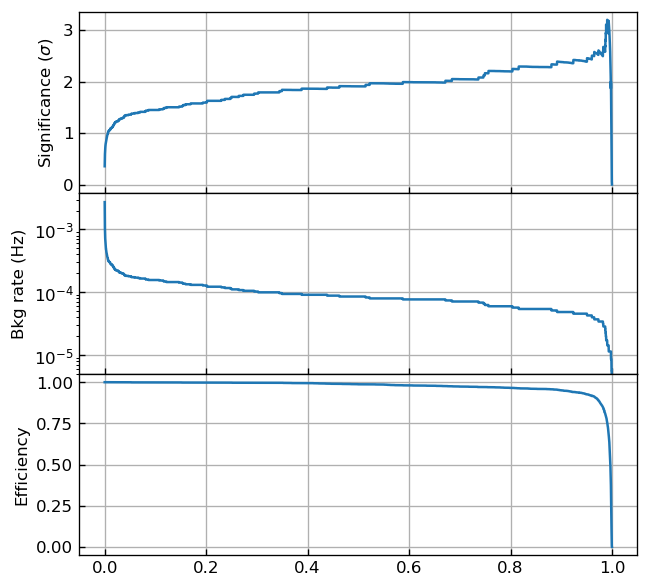

In [139]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax = plot_sig_vs_thr(model,
                     X_test,
                     ml.y_test,
                     t_obs_hours=t_tot_hrs,
                     N_tot=y_train.size + y_val.size + ml.y_test.size,
                     step=0.0001
                     )
plt.subplots_adjust(hspace=0.)

### Plot misidentified pulses

In [130]:
threshold = 0.992
class_pred_test = (y_pred_test > threshold).flatten().astype(int)
false_positive_test = (class_pred_test == 1) & (ml.y_test == 0)
false_negative_test = (class_pred_test == 0) & (ml.y_test == 1)

#### False positives

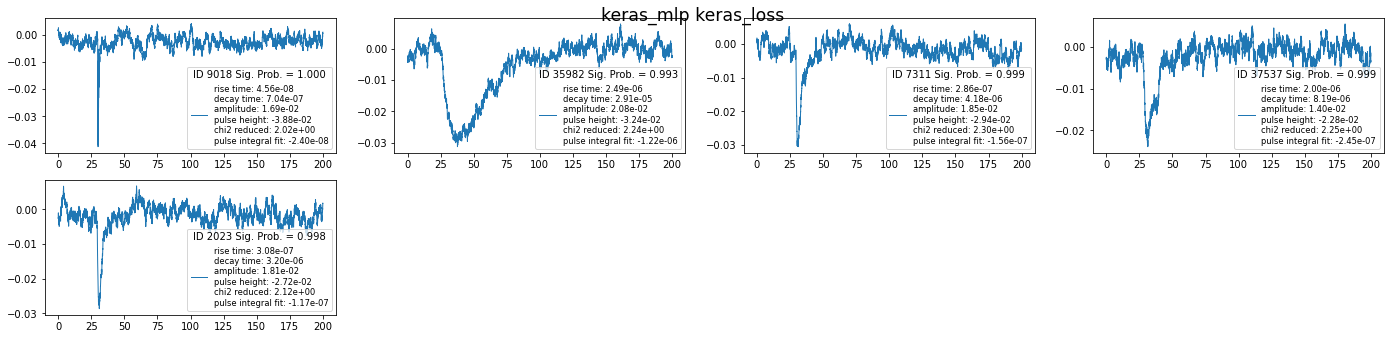

In [131]:
d = {}
d['y_test'] = ml.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = ml.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred_test, y_pred_test])}
d['classifier'] = "keras_mlp"

if false_positive_test.sum() < 50:
    ax = ml.plot_misidentified_time_lines(
        d, scorer,
        data['time'],
        data['data'],
        X=X,  # give original data, for right values in legend
        feature_names=feature_names,
        plot_false_positive=True, save_plot=False
    )

#### False negatives

In [132]:
d = {}
d['y_test'] = ml.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = ml.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred_test, y_pred_test])}
d['classifier'] = "keras_mlp"

if false_negative_test.sum() < 50:
    ax = ml.plot_misidentified_time_lines(
        d, scorer,
        data['time'],
        data['data'],
        X=X_log,  # give original data, for right values in legend
        feature_names=feature_names,
        plot_false_positive=False,
        save_plot=False
    )
else:
    print(f"False negatives too high for plotting: {false_negative_test.sum():n}")

False negatives too high for plotting: 517


In [133]:
feature_names

['rise time',
 'decay time',
 'amplitude',
 'pulse height',
 'chi2 reduced',
 'pulse integral fit']

In [134]:
# test samples with true positives
tp_idx = (class_pred_test == 1) & (ml.y_test == 1)

In [135]:
# energy resolution

# get pulse integral of true positives
pi = X_test.numpy()[tp_idx, feature_names.index("pulse integral fit")]

0.24202375


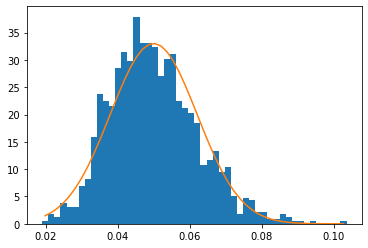

In [136]:
n, bins, _ = plt.hist(10.**pi, bins=50, density=True)
cen = 0.5*(bins[1:] + bins[:-1])

plt.plot(cen, norm.pdf(cen, loc=np.mean(10.**pi), scale=np.sqrt(np.var(10.**pi))))
print(np.sqrt(np.var(10.**pi))/np.mean(10.**pi))

In [137]:
from scipy.stats import norm